In [46]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, fbeta_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
import torch
from tabpfn import TabPFNClassifier, TabPFNRegressor

from dotenv import load_dotenv
load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

Previously in feature engineering part, we have identified longitude, latitude, dmin, nst, Year, Month, month_number do not seem to be useful. We will check this insight with our models. Baseline will not include any of these features.

In [48]:
features_to_exclude = ['tsunami', 'Year', 'Month','month_number','dmin','nst','longitude','latitude']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Creating Models

In [49]:
clf = TabPFNClassifier(device=device)
clf.fit(X_train.values, y_train.values)

regressor = TabPFNRegressor(device=device)  # Uses TabPFN-2.5 weights, trained on synthetic data only.
regressor.fit(X_train.values, y_train.values)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,average_before_softmax,False
,model_path,'auto'
,device,device(type='cuda')
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'
,random_state,0


In [50]:
prediction_probabilities = clf.predict_proba(X_test)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))



c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.9170223507274313


c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


Accuracy 0.8828571428571429


## Analyze the result of TabPFNClassifier

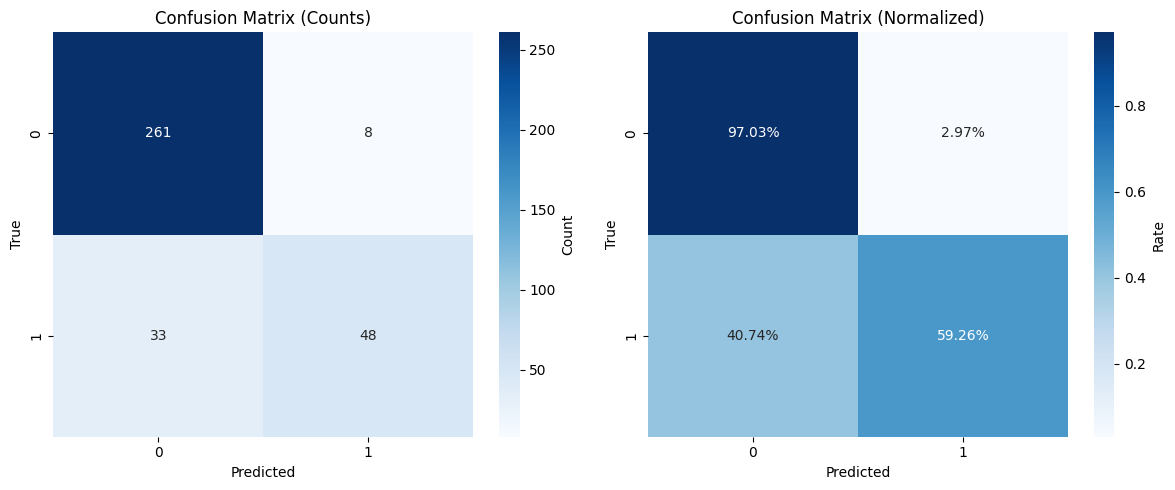

c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(
c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


,0
timestamp,2025-11-17 03:19:23
model,TabPFNClassifier
cv_splits,5
scaler,StandardScaler
class_weight,N/A
test_accuracy,0.882857
test_precision,0.857143
test_recall,0.592593
test_f1,0.70073
test_f2,0.631579


In [51]:

cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.tight_layout(); plt.show()

# Train metrikleri
train_pred = clf.predict(X_train)
train_proba = clf.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
train_precision = precision_score(y_train, train_pred, zero_division=0)
train_recall = recall_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
train_f2 = fbeta_score(y_train, train_pred, beta=2.0, zero_division=0)
train_roc_auc = roc_auc_score(y_train, train_proba[:, 1])

# Test metrikleri (zaten hesaplanmış değişkenleri kullanıyoruz)
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, zero_division=0)
test_recall = recall_score(y_test, predictions)
test_f1 = f1_score(y_test, predictions)
test_f2 = fbeta_score(y_test, predictions, beta=2.0, zero_division=0)
test_roc_auc = roc_auc_score(y_test, prediction_probabilities[:, 1])

# False negative rate hesapla
fn_rate = cm[1, 0] / cm[1, :].sum() * 100

# Sonuçları kaydet
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # sadece raporlamak için

tabpfn_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "TabPFNClassifier",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",
    "class_weight": "N/A",
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_f2": test_f2,
    "test_roc_auc": test_roc_auc,
    "train_accuracy": train_accuracy,
    "train_precision": train_precision,
    "train_recall": train_recall,
    "train_f1": train_f1,
    "train_f2": train_f2,
    "train_roc_auc": train_roc_auc,
    "train_test_gap_accuracy": train_accuracy - test_accuracy,
    "false_negative_rate": fn_rate,
    "notes": ""
}

new_results_df = pd.DataFrame([tabpfn_results])

# Save results to CSV
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_csv = results_dir / "model_results.csv"

if results_csv.exists():
    existing_results = pd.read_csv(results_csv)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_csv(results_csv, index=False)
else:
    new_results_df.to_csv(results_csv, index=False)

new_results_df.T


## TabPFNClassifier Results Summary

**Key Findings:**
- **Test Accuracy**: 0.8829 (88.29%)
- **Test Precision**: 0.8571 (85.71%)
- **Test Recall**: 0.5926 (59.26%)
- **Test F1 Score**: 0.7007 (70.07%)
- **Test F2 Score**: 0.6316 (63.16%)
- **Test ROC-AUC**: 0.9170 (91.70%) - Excellent class separation
- **False Negative Rate**: 40.74% - Critical concern: not being able to detect over 40% of tsunamis can lead to dangerous outcomes
- **Train/Test Gap (Accuracy)**: 0.0086 (0.86%) - Minimal overfitting

**Analysis:**
While TabPFN achieves high accuracy (88.29%) and excellent ROC-AUC (91.70%), the high false negative rate of 40.74% is unacceptable for tsunami detection, as missing tsunamis can have catastrophic consequences.

## Analyze the TabPFNRegressor
We can try multiple selection metrics and multiple thresholds to get a feasible outcome.

In [52]:
from sklearn.metrics import (
    balanced_accuracy_score,
    matthews_corrcoef,
    fbeta_score,
    roc_curve,
)

# Sürekli skorlar
reg_scores_test = regressor.predict(X_test)
reg_scores_train = regressor.predict(X_train)

# Eşik adayları: linspace ∪ (tahmin skorlarından türetilen yuvarlanmış değerler)
candidate_thresholds = sorted(set(np.linspace(0.01, 0.99, 99)) | set(np.round(reg_scores_test, 4)))

# Tüm eşikler için metrikler (test seti)
rows = []
for t in candidate_thresholds:
    preds_t = (reg_scores_test >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, preds_t),
        "precision": precision_score(y_test, preds_t, zero_division=0),
        "recall": recall_score(y_test, preds_t),
        "f1": f1_score(y_test, preds_t),
        "f0_5": fbeta_score(y_test, preds_t, beta=0.5, zero_division=0),
        "f1_5": fbeta_score(y_test, preds_t, beta=1.5, zero_division=0),
        "f2": fbeta_score(y_test, preds_t, beta=2.0, zero_division=0),
        "f5": fbeta_score(y_test, preds_t, beta=5.0, zero_division=0),
        "f10": fbeta_score(y_test, preds_t, beta=10.0, zero_division=0),
        "f20": fbeta_score(y_test, preds_t, beta=20.0, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_test, preds_t),
        "mcc": matthews_corrcoef(y_test, preds_t) if len(np.unique(preds_t)) > 1 else 0.0,
    })
thr_df = pd.DataFrame(rows)

# Hangi metriklere göre en iyi eşiği raporlayalım
metrics_to_use = ["f1", "precision", "recall", "accuracy", "balanced_accuracy", "mcc", "f0_5", "f1_5", "f2", "f5"]

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for metric in metrics_to_use:
   
    used_threshold = float(thr_df.loc[thr_df[metric].idxmax(), "threshold"])

    # Nihai tahminler
    reg_pred_test = (reg_scores_test >= used_threshold).astype(int)
    reg_pred_train = (reg_scores_train >= used_threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, reg_pred_test)

    # Test metrikleri
    test_accuracy = accuracy_score(y_test, reg_pred_test)
    test_precision = precision_score(y_test, reg_pred_test, zero_division=0)
    test_recall = recall_score(y_test, reg_pred_test)
    test_f1 = f1_score(y_test, reg_pred_test)
    test_roc_auc = roc_auc_score(y_test, reg_scores_test)  # sürekli skorla

    # Train metrikleri (aynı eşik)
    train_accuracy = accuracy_score(y_train, reg_pred_train)
    train_precision = precision_score(y_train, reg_pred_train, zero_division=0)
    train_recall = recall_score(y_train, reg_pred_train)
    train_f1 = f1_score(y_train, reg_pred_train)
    train_roc_auc = roc_auc_score(y_train, reg_scores_train)

    results.append({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": "TabPFNRegressor",
        "cv_splits": skf.get_n_splits(),
        "scaler": "StandardScaler",
        "class_weight": "N/A",
        "selection_metric": metric,
        "used_threshold": used_threshold,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1,
        "test_roc_auc": test_roc_auc,
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_f1": train_f1,
        "train_roc_auc": train_roc_auc,
        "train_test_gap_accuracy": train_accuracy - test_accuracy,
        "cm_tp%": int(cm[1,1]/cm.sum()*100),
        "cm_fp%": int(cm[0,1]/cm.sum()*100),
        "cm_tn%": int(cm[0,0]/cm.sum()*100),
        "cm_fn%": round((cm[1,0]/cm.sum()*100), 2),
        "notes": ""
    })

results_df = pd.DataFrame(results)

# Özet görünüm
results_summary_df = results_df[["selection_metric","used_threshold","test_accuracy","test_precision","test_recall","test_f1","test_roc_auc","cm_fn%"]]
display(thr_df.sort_values("f1", ascending=False).head())
display(results_summary_df)
# ...existing code...

c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(
c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(


,threshold,accuracy,precision,recall,f1,f0_5,f1_5,f2,f5,f10,f20,balanced_accuracy,mcc
204,0.3363,0.882857,0.770270,0.703704,0.735484,0.755968,0.722927,0.716080,0.706051,0.704306,0.703855,0.820253,0.661564
202,0.3300,0.880000,0.760000,0.703704,0.730769,0.748031,0.720117,0.714286,0.705714,0.704220,0.703834,0.818395,0.654512
203,0.3302,0.880000,0.760000,0.703704,0.730769,0.748031,0.720117,0.714286,0.705714,0.704220,0.703834,0.818395,0.654512
205,0.3400,0.880000,0.767123,0.691358,0.727273,0.750670,0.713026,0.705290,0.693994,0.692035,0.691528,0.814080,0.652061
200,0.3200,0.877143,0.750000,0.703704,0.726115,0.740260,0.717328,0.712500,0.705378,0.704134,0.703812,0.816536,0.647574


,selection_metric,used_threshold,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,cm_fn%
0,f1,0.3363,0.882857,0.770270,0.703704,0.735484,0.917252,6.86
1,precision,0.7521,0.805714,1.000000,0.160494,0.276596,0.917252,19.43
2,recall,0.0004,0.234286,0.232092,1.000000,0.376744,0.917252,0.00
3,accuracy,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
4,balanced_accuracy,0.2130,0.854286,0.653061,0.790123,0.715084,0.917252,4.86
5,mcc,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
6,f0_5,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
7,f1_5,0.1683,0.834286,0.603604,0.827160,0.697917,0.917252,4.00
8,f2,0.0384,0.737143,0.467066,0.962963,0.629032,0.917252,0.86
9,f5,0.0025,0.542857,0.336100,1.000000,0.503106,0.917252,0.00


## The crucial point for this problem is to not have false negatives(FN).
The reason behind this is we want to alert residents in case of a possible tsunami. Having a false negative means that a tsunami happened and our system did not detect it. This is the case we want to avoid.
So far we have recommended different selection metrics. Let's compare the different selections metrics that have minimal false negatives.

In [53]:
display(results_summary_df.sort_values("cm_fn%"))

,selection_metric,used_threshold,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,cm_fn%
2,recall,0.0004,0.234286,0.232092,1.000000,0.376744,0.917252,0.00
9,f5,0.0025,0.542857,0.336100,1.000000,0.503106,0.917252,0.00
8,f2,0.0384,0.737143,0.467066,0.962963,0.629032,0.917252,0.86
7,f1_5,0.1683,0.834286,0.603604,0.827160,0.697917,0.917252,4.00
4,balanced_accuracy,0.2130,0.854286,0.653061,0.790123,0.715084,0.917252,4.86
0,f1,0.3363,0.882857,0.770270,0.703704,0.735484,0.917252,6.86
5,mcc,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
3,accuracy,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
6,f0_5,0.4100,0.888571,0.862069,0.617284,0.719424,0.917252,8.86
1,precision,0.7521,0.805714,1.000000,0.160494,0.276596,0.917252,19.43


- As expected using recall as the selection metric catches all tsunamis and does not have a single false negative example but test accuracy is only 23%. 
- Using f5 as the selection metric also catches all tsunamis and does not have a single false negative example. Eventhough test accuracy is significantly better it is still not quite acceptable.
- Using f2 as the selection metric catches 96% of all tsunamis results in 0.86% false negatives which is acceptabe and accuracy increases to 74%.
- Using f1_5 or balanced accuracy as the selection metric catches 82% of all tsunamis and results in 4% false negatives. In a serious matter that is about human life this is a risky metric to use but it offers 83% accuracy.
- Using f1 as the selection metric catches 70% of all tsunamis and results in 6.86% false negatives. This is also a risky metric for such a serious matter like tsunami detection. However this metric offers 88% accuracy.

The rest of the metrics do not offer a feasible trade off between false negative ratio and the accuracy.

In [54]:
results_df[(results_df['selection_metric'] == 'f2') | (results_df['selection_metric'] == 'f1_5') | (results_df['selection_metric'] == 'f1')].T

,0,7,8
timestamp,2025-11-17 03:19:29,2025-11-17 03:19:29,2025-11-17 03:19:29
model,TabPFNRegressor,TabPFNRegressor,TabPFNRegressor
cv_splits,5,5,5
scaler,StandardScaler,StandardScaler,StandardScaler
class_weight,N/A,N/A,N/A
selection_metric,f1,f1_5,f2
used_threshold,0.3363,0.1683,0.0384
test_accuracy,0.882857,0.834286,0.737143
test_precision,0.77027,0.603604,0.467066
test_recall,0.703704,0.82716,0.962963


## Baseline models are set
By using TabPFNRegressor with selection metric 'f2' with user threshold at 0.383 we have managed to catch over 96% of tsunamis and achieved over 73% accuracy. 

Next step is to examine the features with our model and achive a better outcome than our baseline.

## Feature Importance Analysis

Since our baseline models did not include the features listed above, we should start by creating new datasets and new models to set up.